<div
      style="
        text-align: center;
        font-weight: bold;
        font-size: 32px;
        font-family: Arial, Helvetica, sans-serif;
        color: white;
        background-color: rgb(84, 84, 84);
        padding-top: 20px;
        padding-bottom: 20px;
        border-radius: 20px;
      "
    >
      CMI | Problematic Internet Use
    </div>

# I. Import Library

In [1]:
import numpy as np
import pandas as pd
import polars as pl

import os
import time
import copy
import gc
import json
import random
from pathlib import Path

import itertools
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from colorama import Style, Fore

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from IPython.display import clear_output

import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

N_FOLD = 5
SEED = 42


# II. Data Exploration

## 1. Load & Preview Data

In [2]:
train_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')


train_data_col = train_data.columns.tolist()
test_data_col = test_data.columns.tolist()
print('Train shape and Test shape:')
train_data.shape, test_data.shape

Train shape and Test shape:


((3960, 81), (20, 58))

In [3]:
train_data.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
id,,,,,,,,,,,,,,,,,,,,,
00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_data.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
id,,,,,,,,,,,,,,,,,,,,,
00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


## 2. Missing values in train & test dataset

Duplicates in dtrain: 137
Duplicates in dtest: 0
Percentage of null values in each column in train dataset
Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                       30.909091
Length: 81, dtype: float64


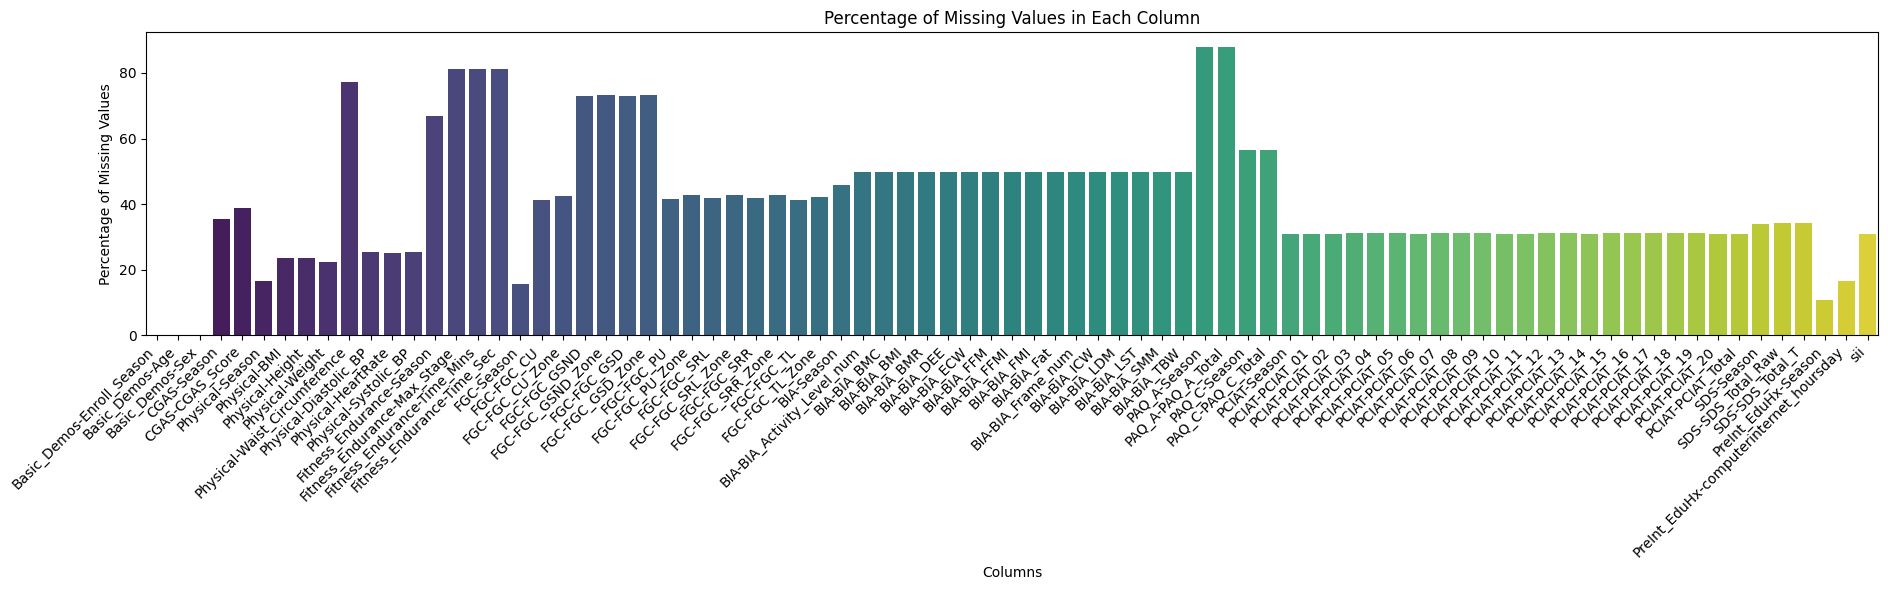

In [6]:
print('Duplicates in dtrain:', train_data.duplicated().sum())
print('Duplicates in dtest:', test_data.duplicated().sum())

print('Percentage of null values in each column in train dataset')

print(train_data.isnull().mean() * 100)

missing_percentage = train_data.isnull().mean() * 100


plt.figure(figsize=(19, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.tight_layout()
plt.show()

Percentage of null values in each column in test dataset


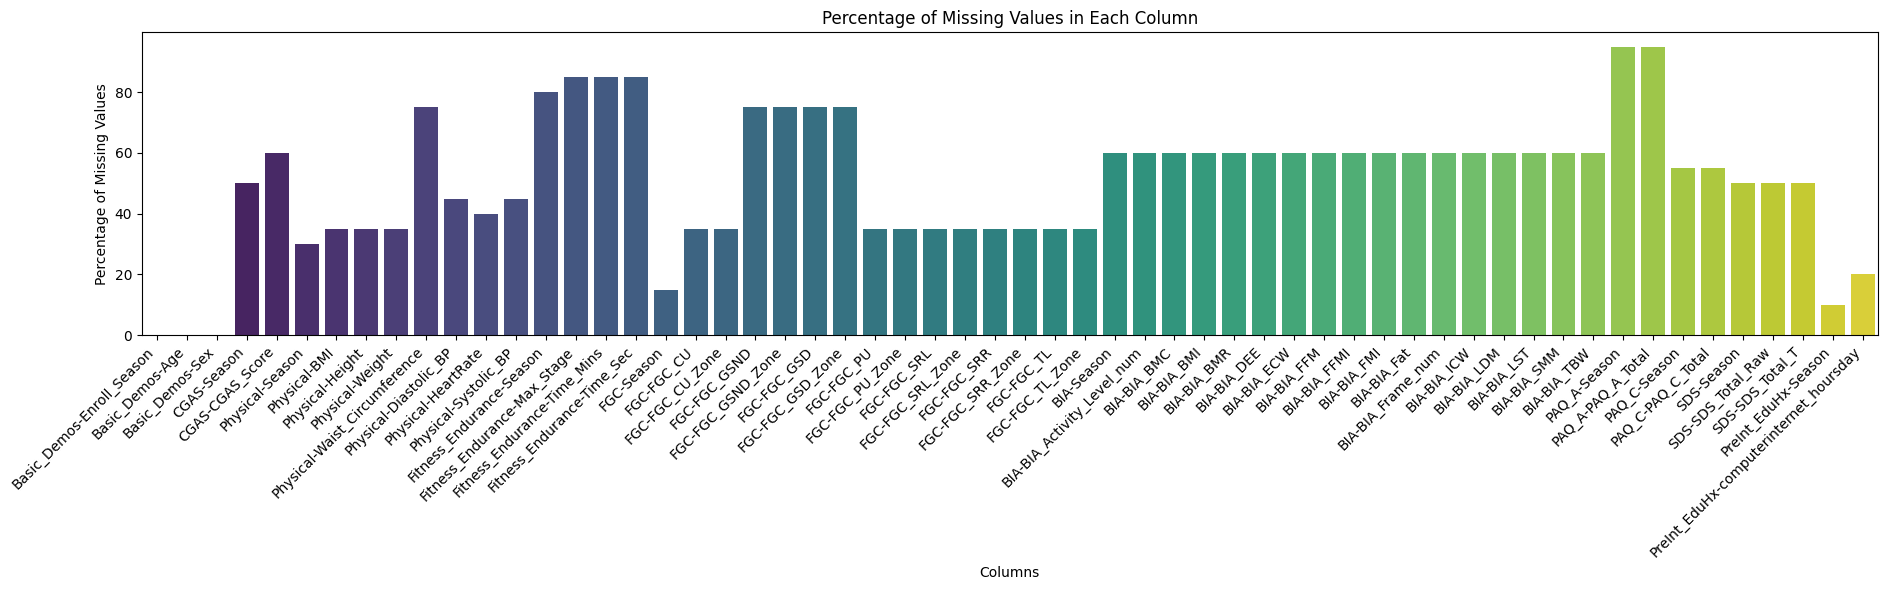

In [7]:
print('Percentage of null values in each column in test dataset')
test_data.isnull().mean() * 100

missing_percentage = test_data.isnull().mean() * 100


plt.figure(figsize=(19, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.tight_layout()
plt.show()

As we can see:
- there are duplicates data in train dataset
- on both train and test data, columns revelant to `Season` have high missing percentage, so we can drop these columns.

## 3. Train & Test differences
Let's see what columns in train dataset but not in test dataset

In [8]:
columns_not_in_test = sorted(list(set(train_data_col) - set(test_data_col)))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


As the result, the test dataset includes all feature columns in the train dataset (except 22 PCIAT scores and sii score)

## 4. Features statistics

In [9]:
features = test_data_col.copy()
print('#Features :', len(features))

# Numerical Features
num_features = [f for f in features if train_data[f].dtype==float or f=='Basic_Demos-Age']
print('#numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('#categorical features :', len(cat_features))

# Target Features
target_col = [f for f in train_data_col if f not in test_data_col]
print('#target features :', len(target_col), '\n')

# Unique Number
print('Unique #values in each set\n')
# pd.set_option('display.max_rows', 500)
pd.DataFrame(data= {'Unique number in train': train_data[features].nunique(), 
                    'Unique number in test': test_data[features].nunique()}).sort_values(by=['Unique number in train']) 

#Features : 58
#numerical features : 47
#categorical features : 11
#target features : 23 

Unique #values in each set



,Unique number in train,Unique number in test
Basic_Demos-Sex,2,2
FGC-FGC_SRL_Zone,2,2
FGC-FGC_TL_Zone,2,2
FGC-FGC_SRR_Zone,2,2
FGC-FGC_PU_Zone,2,2
FGC-FGC_CU_Zone,2,2
FGC-FGC_GSND_Zone,3,2
FGC-FGC_GSD_Zone,3,2
BIA-BIA_Frame_num,3,2
FGC-Season,4,4


### Features groups

In [10]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

## 5. Distribution of sii and PCIAT scores

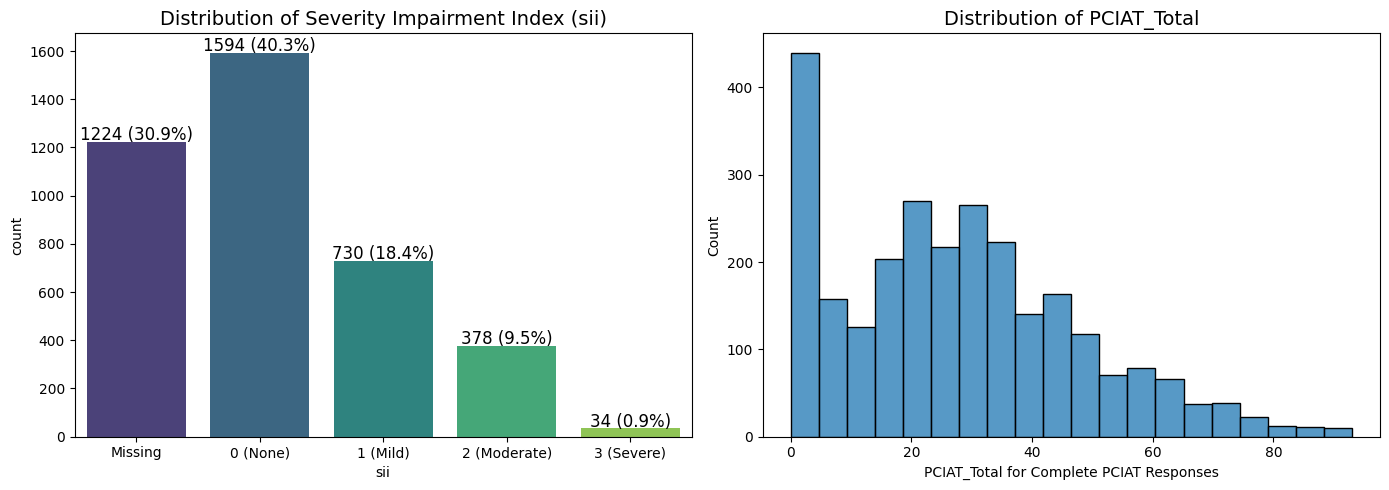

In [11]:
train = train_data.copy()
sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

sii = train['sii'].value_counts().reset_index()
sii_total = sii['count'].sum()
sii['percentage'] = (sii['count'] / sii_total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii.loc[sii['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )


PCIAT_columns = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_columns].notna().all(axis=1), np.nan
)
# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

## 6. `sii` distribution for each Age group

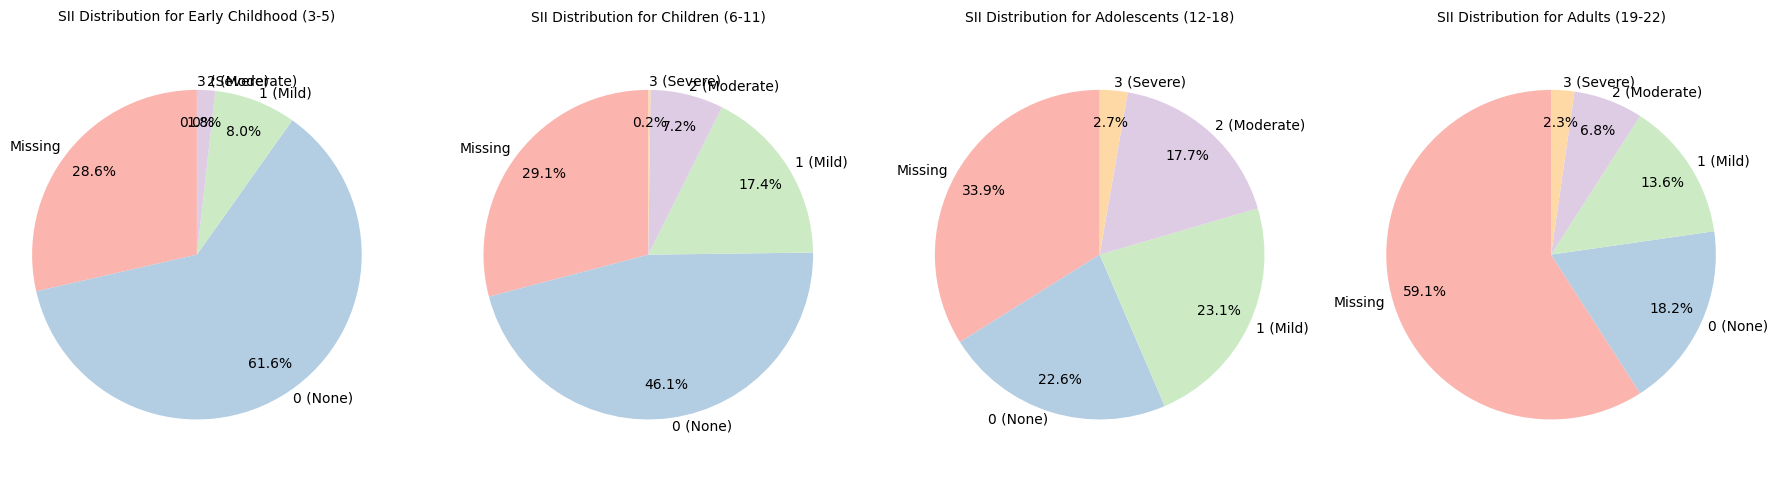

In [12]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[2, 5, 12, 18, 22],
    labels=['Early Childhood (3-5)', 'Children (6-11)', 'Adolescents (12-18)', 'Adults (19-22)']
)

stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

valid_age_groups = [age_group for age_group in stats.index if stats.loc[age_group].sum() > 0]

for i, age_group in enumerate(valid_age_groups):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Pastel1"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}', fontsize=10)
    axes[i].axis('equal')  # Ensures pie chart is a circle

plt.tight_layout()
plt.show()

## 7. Seasons distribution

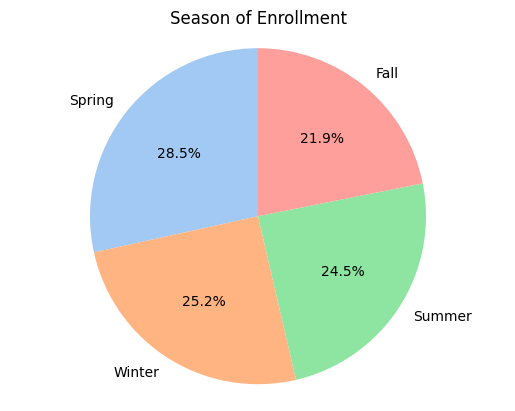

In [13]:
import seaborn as sns

season = train['Basic_Demos-Enroll_Season'].value_counts()

colors = sns.color_palette("pastel", len(season))

plt.pie(
    season.values,
    labels=season.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Season of Enrollment')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.show()

- The enrollment is distributed relatively evenly across the four seasons (Fall, Spring, Summer, and Winter). While there are slight variations, no single season dominates the enrollment numbers. This suggests that students enroll throughout the year, and the institution might not experience significant enrollment peaks or lulls tied to specific seasons.
- Spring has the highest percentage of enrollment at 28.5%, indicating it's the most popular time for students to begin or continue their studies. This could be due to various factors, such as academic calendar structures or student preferences.
- Fall has the lowest percentage of enrollment at 21.9%. This is somewhat unexpected, as Fall is traditionally a common start time for academic years in many educational systems. This lower percentage might warrant further investigation to understand the underlying reasons.
- Summer (24.5%) and Winter (25.2%) have very similar enrollment percentages. This suggests a consistent level of student engagement during these off-peak seasons, possibly driven by specialized programs, shorter courses, or students seeking to accelerate their studies.

## 8. Gender distribution

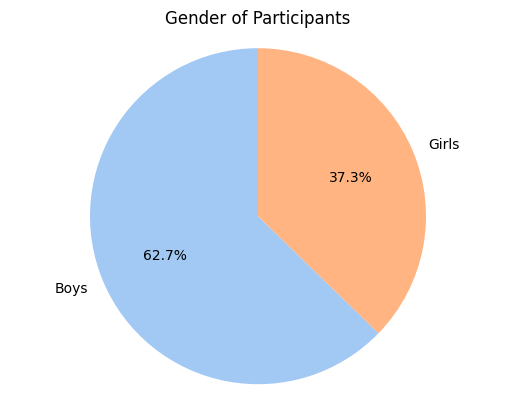

In [14]:
gender = train['Basic_Demos-Sex'].value_counts()

plt.pie(
    gender.values,  # Tần suất
    labels=['Boys', 'Girls'],  # Nhãn
    autopct='%1.1f%%',  # Hiển thị tỉ lệ phần trăm
    startangle=90,  # Bắt đầu từ góc 90 độ
    colors=sns.color_palette('pastel')[:2]  # Sử dụng màu pastel
)
plt.title('Gender of Participants')
plt.axis('equal')  # Đảm bảo biểu đồ tròn không bị méo
plt.show()


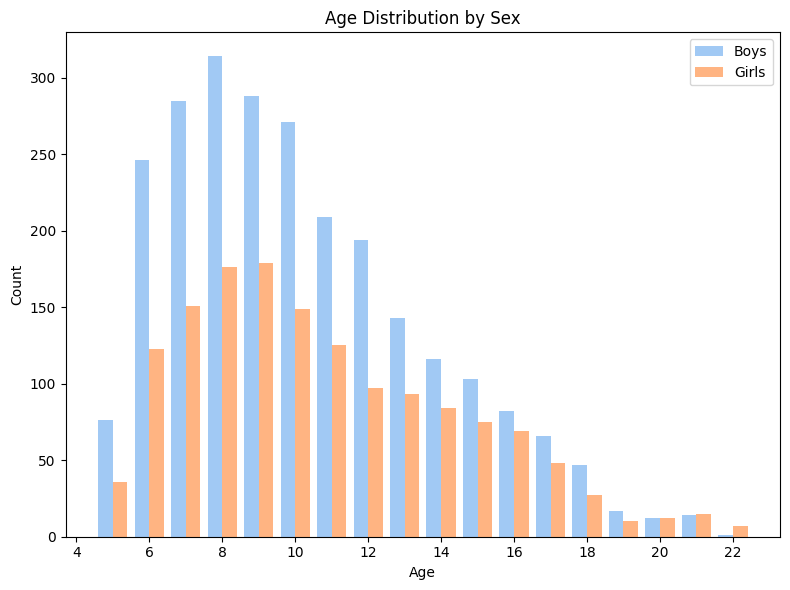

In [15]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8, 6))

boys_data = train[train['Basic_Demos-Sex'] == 0]['Basic_Demos-Age'].value_counts().sort_index()
girls_data = train[train['Basic_Demos-Sex'] == 1]['Basic_Demos-Age'].value_counts().sort_index()

ages = sorted(set(boys_data.index).union(girls_data.index))

boys_counts = [boys_data.get(age, 0) for age in ages]
girls_counts = [girls_data.get(age, 0) for age in ages]

# Chọn độ rộng của cột
width = 0.4

# Tạo các cột kép
ax.bar(np.array(ages) - width/2, boys_counts, width=width, color=sns.color_palette('pastel')[0], label='Boys')
ax.bar(np.array(ages) + width/2, girls_counts, width=width, color=sns.color_palette('pastel')[1], label='Girls')

# Thiết lập các trục và nhãn
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Hiển thị giá trị nguyên trên trục x
ax.set_ylabel('Count')
ax.set_xlabel('Age')
ax.set_title('Age Distribution by Sex')

# Hiển thị chú thích
ax.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

## 9. Internet Time Usage

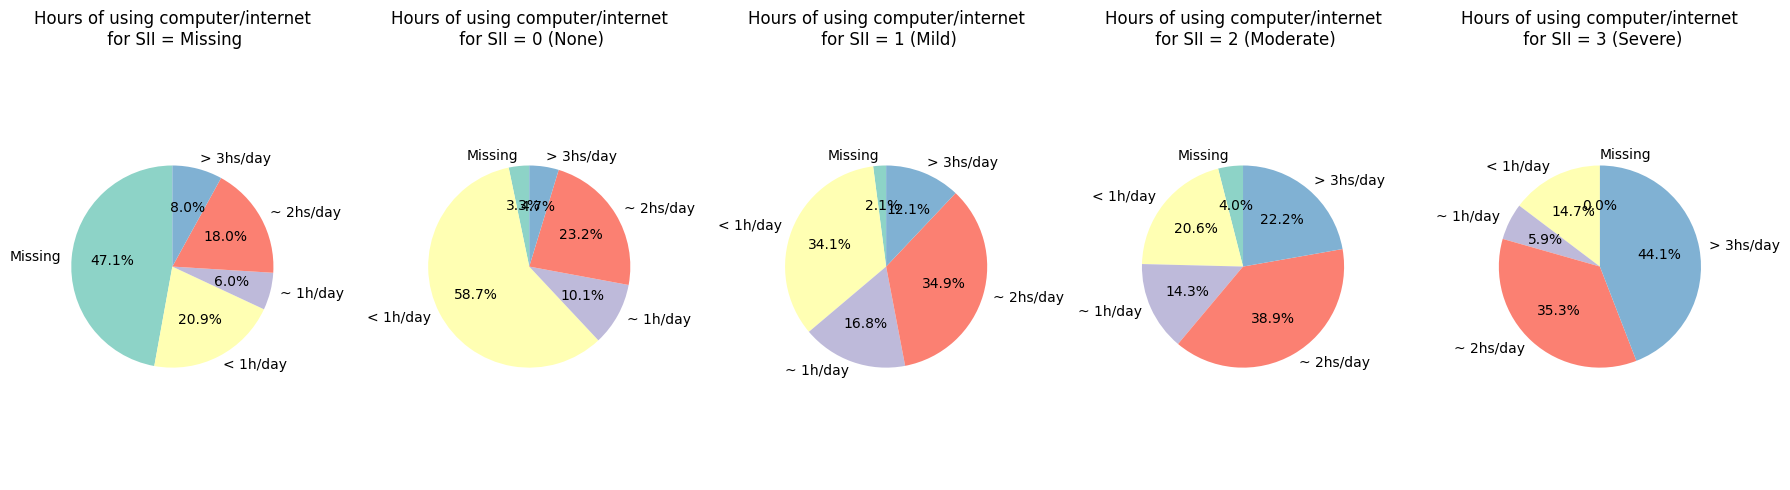

In [16]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

stats = train.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, sii_group in enumerate(stats.index):
    group_counts = stats.loc[sii_group] / stats.loc[sii_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1
    )
    axes[i].set_title(f'Hours of using computer/internet\n for SII = {sii_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

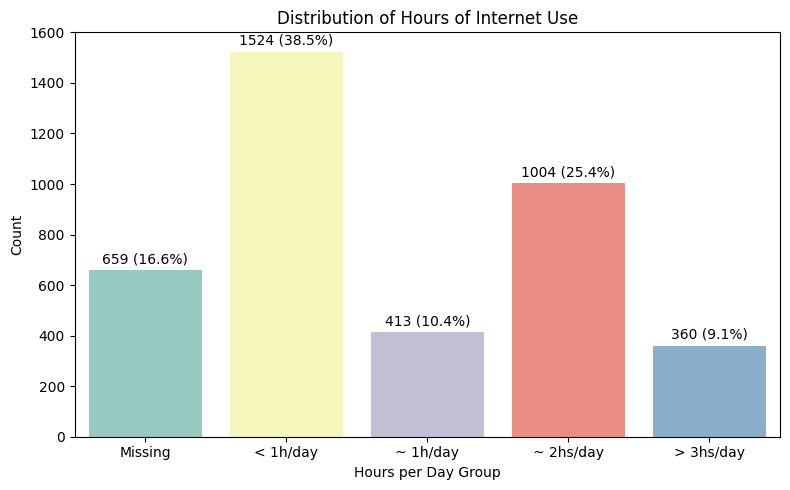

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo figure cho biểu đồ phân phối Hours of Internet Use
fig, ax = plt.subplots(figsize=(8, 5))

# Biểu đồ phân phối Hours of Internet Use
sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=ax)

# Thêm tiêu đề và nhãn cho trục
ax.set_title('Distribution of Hours of Internet Use')
ax.set_xlabel('Hours per Day Group')
ax.set_ylabel('Count')

# Tính tổng số mẫu
total = len(train['internet_use_encoded'])

# Thêm tỷ lệ phần trăm vào mỗi cột
for p in ax.patches:
    count = int(p.get_height())  # Lấy chiều cao của cột
    percentage = '{:.1f}%'.format(100 * count / total)  # Tính phần trăm
    ax.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

## 10. Correlation matrix

Basic_Demos-Age                           0.409559
Basic_Demos-Sex                          -0.093648
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Diastolic_BP                     0.069321
Physical-Systolic_BP                      0.147081
Physical-HeartRate                       -0.037594
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
PAQ_A-PAQ_A_Total                        -0.026854
PAQ_C-PAQ_C_Total                        -0.021943
Fitness_Endurance-Max_Stage              -0.041720
Fitness_Endurance-Time_Mins              -0.052376
Fitness_Endurance-Time_Sec               -0.000373
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                     

<Figure size 1400x3000 with 0 Axes>

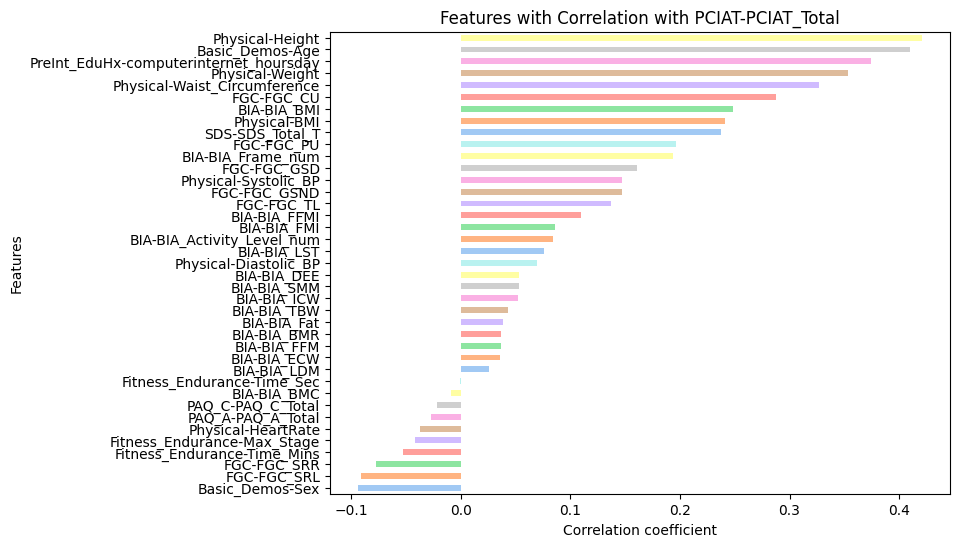

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lọc các giá trị không null cho cột 'sii'
train_with_sii = train[train['sii'].notnull()]

# Tính toán ma trận tương quan
plt.figure(figsize=(14, 30))
corr_matrix = train_with_sii[[
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
]].corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')

# In ra các mối tương quan
print(sii_corr)

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(8, 6))
sii_corr.sort_values().plot(kind='barh', color=sns.color_palette("pastel", len(sii_corr)))
plt.title('Features with Correlation with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()


# III. Time series parquet Exploration

## 1. Load & Preview one participant data

In [19]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet'
series_train = pd.read_parquet(path)
series_train

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [20]:
participant_id = path.split('/')[-2].split('=')[-1]
participant_id

'00115b9f'

In [21]:
train[train['id'] == participant_id]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0


### Helper function

In [22]:
def plot_series_data(df, col='non-wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='day_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    pastel_colors = sns.color_palette("pastel", 7)
    
    # X
    plt.subplot(7, 1, 1)
    plt.scatter(df[x_col], df['X'], label='X', color=pastel_colors[0], s=1)
    plt.title('X (Acceleration along X axis)')
    plt.ylabel('Acceleration (m/s²)')

    # Y
    plt.subplot(7, 1, 2)
    plt.scatter(df[x_col], df['Y'], label='Y', color=pastel_colors[1], s=1)
    plt.title('Y (Acceleration along Y axis)')
    plt.ylabel('Acceleration (m/s²)')

    # Z
    plt.subplot(7, 1, 3)
    plt.scatter(df[x_col], df['Z'], label='Z', color=pastel_colors[2], s=1)
    plt.title('Z (Acceleration along Z axis)')
    plt.ylabel('Acceleration (m/s²)')
    
    # ENMO
    plt.subplot(7, 1, 4)
    plt.scatter(df[x_col], df['enmo'], label='ENMO', color=pastel_colors[3], s=1)
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(7, 1, 5)
    plt.scatter(df[x_col], df['anglez'], label='Angle Z', color=pastel_colors[4], s=1)
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(7, 1, 6)
    plt.scatter(df[x_col], df['light'], label='Light', color=pastel_colors[5], s=1)
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(7, 1, 7)
    plt.scatter(df[x_col], df[col], label=col, color=pastel_colors[6], s=1)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()


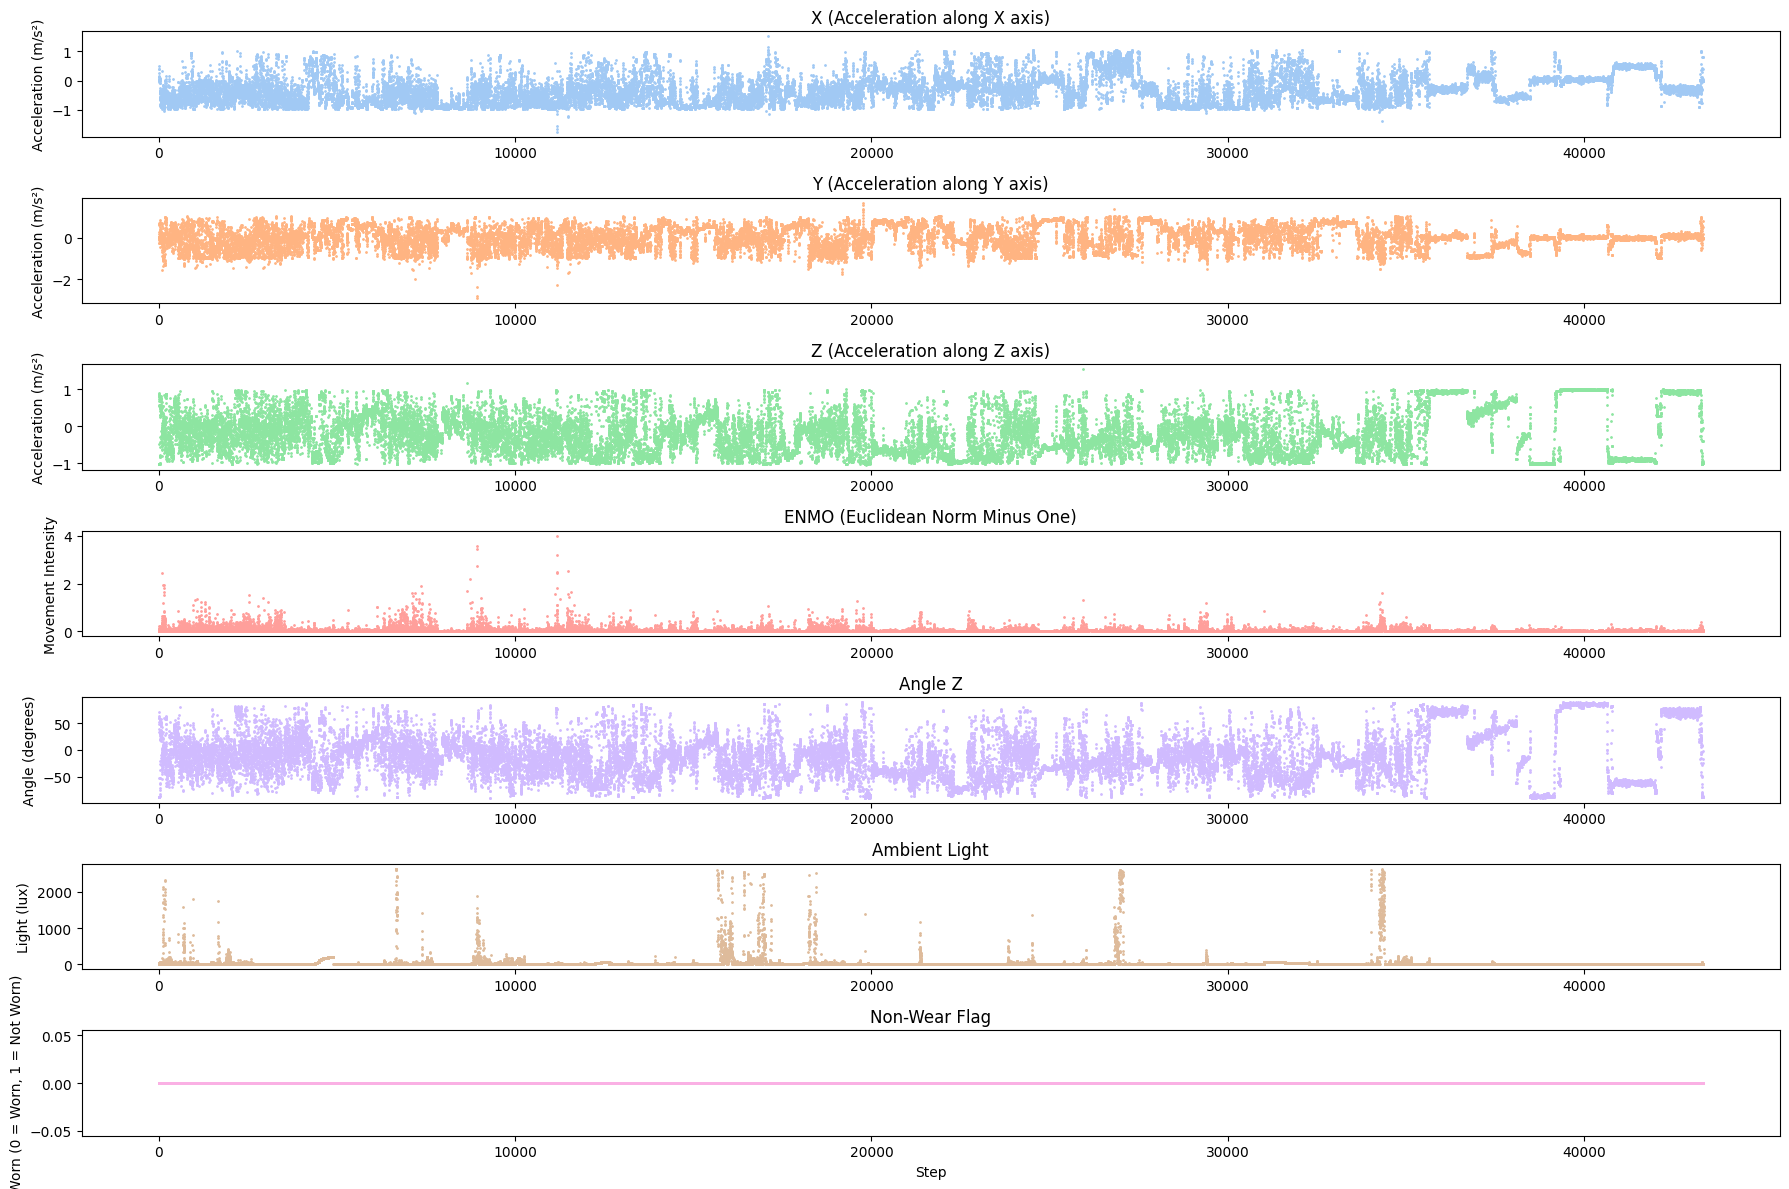

In [23]:
plot_series_data(series_train, x_col='step', x_label='Step')

# Process data

In [24]:
SEED = 42
n_splits = 10
optimize_params = False
n_trials = 25
base_thresholds = [30, 50, 80]
y_model = "PCIAT-PCIAT_Total"
y_comp = "sii"

# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [ ]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

# Code for parallelized computation of time series data from: Sheikh Muhammad Abdullah 

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [26]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train_id = train["id"]
test_id = test["id"]

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

train = train[train[y_comp].notna()] # Keep rows where target is available
train.shape

100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


(2736, 155)

In [27]:
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']

features = [f for f in train.columns if f not in exclude]

cat_col = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

for col in cat_col:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)

In [28]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [29]:
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso

model = Lasso(alpha=0.3, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.3)
imputer.fit_models(model, train, features)

train = imputer.impute(train)
test = imputer.impute(test)

100%|██████████| 132/132 [00:02<00:00, 59.49it/s]


In [30]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73
0,2,5,0,0,51.000000,3,16.877316,46.0,50.8,23.160486,...,4153.695206,3490.377984,-0.088517,1.190031,3880.811504,145.154803,4184.716160,3339.878584,-0.008884,0.373658
1,1,9,0,1,63.979855,3,14.035590,48.0,46.0,22.000000,...,4145.105658,3343.413735,-0.054559,0.905956,3855.472302,154.308980,4161.624059,3264.097370,-0.008884,0.372432
2,1,10,1,3,71.000000,3,16.648696,56.5,75.6,24.954008,...,4136.299111,3350.258301,-0.071628,0.774616,3849.944113,155.244719,4162.738469,3228.683667,-0.008884,0.385941
3,0,9,0,3,71.000000,1,18.292347,56.0,81.6,26.091160,...,4170.000000,3829.000000,-0.080292,1.873160,4066.062744,102.408737,4188.500000,3824.000000,-0.010199,0.265176
5,3,13,1,0,50.000000,1,22.279952,59.5,112.2,29.382049,...,4134.000000,3290.000000,-0.006356,0.510197,3842.060303,152.905746,4175.000000,3098.166748,-0.004666,0.491389


In [31]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73
0,2,5,0,0,51.000000,3,16.877316,46.000000,50.800000,23.160486,...,4153.695206,3490.377984,-0.088517,1.190031,3880.811504,145.154803,4184.716160,3339.878584,-0.008884,0.373658
1,1,9,0,1,63.979855,3,14.035590,48.000000,46.000000,22.000000,...,4145.105658,3343.413735,-0.054559,0.905956,3855.472302,154.308980,4161.624059,3264.097370,-0.008884,0.372432
2,1,10,1,3,71.000000,3,16.648696,56.500000,75.600000,24.954008,...,4136.299111,3350.258301,-0.071628,0.774616,3849.944113,155.244719,4162.738469,3228.683667,-0.008884,0.385941
3,0,9,0,3,71.000000,1,18.292347,56.000000,81.600000,26.091160,...,4170.000000,3829.000000,-0.080292,1.873160,4066.062744,102.408737,4188.500000,3824.000000,-0.010199,0.265176
4,3,18,1,2,65.413857,0,24.305638,70.604011,158.330834,26.416189,...,4160.658988,3480.577847,-0.102357,1.188299,3876.932854,144.922851,4160.561879,3378.666365,-0.008884,0.394215


In [32]:
train = train.drop(columns=['PCIAT-Season'], errors='ignore')
test = test.drop(columns=['PCIAT-Season'], errors='ignore')

In [33]:
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']
train = train.drop(columns=exclude, errors='ignore')

In [34]:
train.shape, test.shape

((2736, 133), (20, 132))

# Train model

In [35]:
def compute_qwk(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return cohen_kappa_score(y_pred, y_true,weights="quadratic")

In [36]:
def round_prediction(y_pred: np.ndarray, thresholds: list) -> np.ndarray:

    return np.where(
        y_pred < thresholds[0],
        0,
        np.where(y_pred < thresholds[1], 1, np.where(y_pred < thresholds[2], 2, 3)),
    )

In [37]:
def evaluate_predictions(thresholds, y_true, y_pred):
    rounded_pred = round_prediction(y_pred, thresholds)
    return -compute_qwk(y_true, rounded_pred)

In [38]:
def train_model(
    train_set: pd.DataFrame, test_set: pd.DataFrame, model, test_id
) -> pd.DataFrame:
    x = train_set.drop("sii", axis=1)
    y = train_set["sii"]

    n_samples = len(y)

    SKF = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    train_kappa_scores = []
    val_kappa_scores = []

    non_rounded_train_pred = np.zeros(n_samples, dtype=float)
    non_rounded_test_pred = np.zeros((len(test_set), N_FOLD), dtype=float)

    for fold, (train_index, val_index) in enumerate(SKF.split(x, y)):
        train_data, val_data = x.iloc[train_index], x.iloc[val_index]
        train_label, val_label = y.iloc[train_index], y.iloc[val_index]

        clone_model = clone(model)
        clone_model.fit(train_data, train_label)

        train_pred = clone_model.predict(train_data)
        val_pred = clone_model.predict(val_data)

        train_kappa_scores.append(
            compute_qwk(train_pred.round(0).astype(int), train_label)
        )

        val_kappa_scores.append(
            compute_qwk(val_pred.round(0).astype(int), val_label)
        )

        non_rounded_train_pred[val_index] = val_pred
        non_rounded_test_pred[:, fold] = clone_model.predict(test_set)

    kappa_optimizer = minimize(
        evaluate_predictions,
        x0=[0.5, 1.5, 2.5],
        args=(y, non_rounded_train_pred),
        method="Nelder-Mead",
    )

    optimized_thresholds = kappa_optimizer.x
    rounded_train_pred = round_prediction(non_rounded_train_pred, optimized_thresholds)
    optimized_train_kappa_score = compute_qwk(rounded_train_pred, y)

    print("Optimized train kappa score:", optimized_train_kappa_score)

    rounded_test_pred = round_prediction(
        non_rounded_test_pred.mean(axis=1), optimized_thresholds
    )

    submisison = pd.DataFrame({"id": test_id, "sii": rounded_test_pred})

    return (submisison, optimized_train_kappa_score)

# Submission 1

## Load data

In [39]:
# Load and encode time series data
# train_ts = load_time_series(TRAIN_PARQUET_PATH)
# test_ts = load_time_series(TEST_PARQUET_PATH)
# encoded_train_ts = encode_time_series(
#     df=train_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# )
# encoded_test_ts = encode_time_series(
#     df=test_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# )
# encoded_train_ts["id"] = train_ts["id"]
# encoded_test_ts["id"] = test_ts["id"]

# Load and process csv data
# train_csv = pd.read_csv(TRAIN_CSV_PATH)
# test_csv = pd.read_csv(TEST_CSV_PATH)
# mapped_train_csv = map_seasons(train_csv.drop("id", axis=1))
# mapped_test_csv = map_seasons(test_csv.drop("id", axis=1))

# mapped_train_csv = mapped_train_csv.dropna(subset={"sii"})

# mapped_train_csv["id"] = train_csv["id"]
# mapped_test_csv["id"] = test_csv["id"]

# Merge csv and time series data
# train = pd.merge(mapped_train_csv, train_ts, how="left", on="id")
# test = pd.merge(mapped_test_csv, test_ts, how="left", on="id")

# train_id = train["id"]
# test_id = test["id"]

# train = train.drop("id", axis=1)
# test = test.drop("id", axis=1)

# Do feature engineering
# train = feature_engineering(train)
# test = feature_engineering(test)

# if np.any(np.isinf(train)):
#     train = train.replace([np.inf, -np.inf], np.nan)

## Find optimal parameters for models

In [40]:
# def objective_xgb(trial):
#     params = {
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
#     }
    
#     model = XGBRegressor(**params, verbosity=0, device="cuda")
#     _, metric = train_model(train, test, model, test_id)
    
#     return metric

In [41]:
# def objective_catb(trial):
#     params = {
#         'depth': trial.suggest_int('depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'iterations': trial.suggest_int('iterations', 50, 500),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#     }
    
#     model = CatBoostRegressor(**params, verbose=0, task_type='GPU')
#     _, metric = train_model(train, test, model, test_id)
    
#     return metric

In [42]:
# def objective_lgbm(trial):
#     params = {
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#     }
    
#     model = LGBMRegressor(**params, verbose=-1, device="GPU")
#     _, metric = train_model(train, test, model, test_id)
    
#     return metric

In [43]:
# study_xgb = optuna.create_study(direction='maximize')
# study_catb = optuna.create_study(direction='maximize')
# study_lgbm = optuna.create_study(direction='maximize')

# def optimize_study(study, objective, n_trials=50):
#     study.optimize(objective, n_trials=n_trials)

# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     futures = [
#         executor.submit(optimize_study, study_xgb, objective_xgb),
#         executor.submit(optimize_study, study_catb, objective_catb),
#         executor.submit(optimize_study, study_lgbm, objective_lgbm)
#     ]
#     concurrent.futures.wait(futures)

# BEST_PARAMS_XGB = study_xgb.best_params
# BEST_PARAMS_CATB = study_catb.best_params
# BEST_PARAMS_LGBM = study_lgbm.best_params

# clear_output(wait=True)

In [44]:
# print(BEST_PARAMS_XGB)
# print(BEST_PARAMS_CATB)
# print(BEST_PARAMS_LGBM)

XGB: {'booster': 'gbtree', 'max_depth': 5, 'learning_rate': 0.032806306822661946, 'n_estimators': 124, 'subsample': 0.7612200524957443, 'colsample_bytree': 0.7879462813404031, 'gamma': 2.27693382985497, 'lambda': 0.0037960352854142705}

CATB: {'depth': 8, 'learning_rate': 0.02999839537419576, 'iterations': 492, 'l2_leaf_reg': 2.3005068330449827}

LGBM: {'num_leaves': 290, 'learning_rate': 0.022351630623035076, 'n_estimators': 110, 'min_child_samples': 36, 'subsample': 0.64715318375847, 'colsample_bytree': 0.5964597906674066, 'reg_alpha': 1.5700746777921748, 'reg_lambda': 2.718790747208782}

## Train

In [45]:
BEST_PARAMS_XGB = {
    "booster": "dart",
    "max_depth": 3,
    "learning_rate": 0.026326840847042142,
    "n_estimators": 98,
    "subsample": 0.8890660258651147,
    "colsample_bytree": 0.5698858280617991,
    "gamma": 3.7021400107634967,
    "lambda": 1.5109673038871425,
    "verbose": 0,
    "random_state": SEED,
}

BEST_PARAMS_CATB = {
    "depth": 7,
    "learning_rate": 0.014654088407572447,
    "iterations": 274,
    "l2_leaf_reg": 4.957148716825033,
    "verbose": 0,
    "random_state": SEED,
}

BEST_PARAMS_LGBM = {
    "num_leaves": 29,
    "learning_rate": 0.014234944977835996,
    "n_estimators": 246,
    "min_child_samples": 49,
    "subsample": 0.7674664773701858,
    "colsample_bytree": 0.879948431560254,
    "reg_alpha": 8.136293189993065,
    "reg_lambda": 3.7353821130911413,
    "verbose": -1,
    "random_state": SEED,
}

BEST_PARAMS_RF = {
    "n_estimators": 493,
    "max_depth": 5,
    "min_samples_split": 6,
    "min_samples_leaf": 1,
    "max_features": None,
    "bootstrap": True,
    "random_state": SEED,
}

BEST_PARAMS_GB = {
    "n_estimators": 295,
    "learning_rate": 0.012215329148983722,
    "max_depth": 3,
    "min_samples_split": 18,
    "min_samples_leaf": 5,
    "subsample": 0.599656091501263,
    "max_features": None,
    "random_state": SEED,
}

In [46]:
# def objective_ensemble(trial):
#     weights = {
#         "weights": [
#             trial.suggest_float("weight_xgb", 0.0, 10.0),
#             trial.suggest_float("weight_catb", 0.0, 10.0),
#             trial.suggest_float("weight_lgbm", 0.0, 10.0),
#         ]
#     }
    
#     model = VotingRegressor(estimators=[
#         ("xgb", XGBRegressor(**BEST_PARAMS_XGB, device="cuda")),
#         ("catb", CatBoostRegressor(**BEST_PARAMS_CATB, task_type="GPU")),
#         ("lgbm", LGBMRegressor(**BEST_PARAMS_LGBM, device="GPU")),
#     ], **weights)
    
#     _, metric = train_model(train, test, model, test_id)
    
#     return metric


# study_ensemble = optuna.create_study(direction='maximize')

# def optimize_study(study, objective, n_trials=50):
#     study.optimize(objective, n_trials=n_trials)

# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     futures = [
#         executor.submit(optimize_study, study_ensemble, objective_ensemble)
#     ]
#     concurrent.futures.wait(futures)

# BEST_WEIGHTS = study_ensemble.best_params

# clear_output(wait=True)

In [47]:
# print(BEST_WEIGHTS)

{'weight_xgb': 0.29143842381072055, 'weight_catb': 0.7223070202458827, 'weight_lgbm': 0.0038376523038045}

In [48]:
imputer = SimpleImputer(strategy='median')

ensemble_model = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**BEST_PARAMS_LGBM))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**BEST_PARAMS_XGB))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**BEST_PARAMS_CATB))])),
])

In [49]:
submission1, _ = train_model(train, test, ensemble_model, test_id)
clear_output(wait=True)

Optimized train kappa score: 0.4720975382740742


# Submission 2

In [50]:
# # Load and encode time series data
# train_ts = load_time_series(TRAIN_PARQUET_PATH)
# test_ts = load_time_series(TEST_PARQUET_PATH)
# # encoded_train_ts = encode_time_series(
# #     df=train_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# # )
# # encoded_test_ts = encode_time_series(
# #     df=test_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# # )
# # encoded_train_ts["id"] = train_ts["id"]
# # encoded_test_ts["id"] = test_ts["id"]

# # Load and process csv data
# train_csv = pd.read_csv(TRAIN_CSV_PATH)
# test_csv = pd.read_csv(TEST_CSV_PATH)
# mapped_train_csv = map_seasons(train_csv.drop("id", axis=1))
# mapped_test_csv = map_seasons(test_csv.drop("id", axis=1))

# mapped_train_csv = mapped_train_csv.dropna(subset={"sii"})

# mapped_train_csv["id"] = train_csv["id"]
# mapped_test_csv["id"] = test_csv["id"]

# # Merge csv and time series data
# train = pd.merge(mapped_train_csv, train_ts, how="left", on="id")
# test = pd.merge(mapped_test_csv, test_ts, how="left", on="id")

# train_id = train["id"]
# test_id = test["id"]

# train = train.drop("id", axis=1)
# test = test.drop("id", axis=1)

# # Do feature engineering
# # train = feature_engineering(train)
# # test = feature_engineering(test)

# if np.any(np.isinf(train)):
#     train = train.replace([np.inf, -np.inf], np.nan)

In [51]:
imputer = SimpleImputer(strategy='median')

ensemble_model = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**BEST_PARAMS_LGBM))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**BEST_PARAMS_XGB))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**BEST_PARAMS_CATB))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(**BEST_PARAMS_RF))])),
])

In [52]:
submission2, _ = train_model(train, test, ensemble_model, test_id)
clear_output(wait=True)

Optimized train kappa score: 0.46852883825436265


# Submission 3

In [53]:
# # Load and encode time series data
# train_ts = load_time_series(TRAIN_PARQUET_PATH)
# test_ts = load_time_series(TEST_PARQUET_PATH)
# # encoded_train_ts = encode_time_series(
# #     df=train_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# # )
# # encoded_test_ts = encode_time_series(
# #     df=test_ts.drop("id", axis=1), encoding_dim=60, batch_size=32, epochs=150
# # )
# # encoded_train_ts["id"] = train_ts["id"]
# # encoded_test_ts["id"] = test_ts["id"]

# # Load and process csv data
# train_csv = pd.read_csv(TRAIN_CSV_PATH)
# test_csv = pd.read_csv(TEST_CSV_PATH)
# mapped_train_csv = map_seasons(train_csv.drop("id", axis=1))
# mapped_test_csv = map_seasons(test_csv.drop("id", axis=1))

# mapped_train_csv = mapped_train_csv.dropna(subset={"sii"})

# mapped_train_csv["id"] = train_csv["id"]
# mapped_test_csv["id"] = test_csv["id"]

# # Merge csv and time series data
# train = pd.merge(mapped_train_csv, train_ts, how="left", on="id")
# test = pd.merge(mapped_test_csv, test_ts, how="left", on="id")

# train_id = train["id"]
# test_id = test["id"]

# train = train.drop("id", axis=1)
# test = test.drop("id", axis=1)

# # Do feature engineering
# # train = feature_engineering(train)
# # test = feature_engineering(test)

# if np.any(np.isinf(train)):
#     train = train.replace([np.inf, -np.inf], np.nan)

In [54]:
imputer = SimpleImputer(strategy='median')

ensemble_model = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(**BEST_PARAMS_LGBM))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(**BEST_PARAMS_XGB))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(**BEST_PARAMS_CATB))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(**BEST_PARAMS_RF))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(**BEST_PARAMS_GB))]))
])

In [55]:
submission3, _ = train_model(train, test, ensemble_model, test_id)
clear_output(wait=True)

Optimized train kappa score: 0.46982383341234657


# Final submission

In [56]:
stacked_submission = pd.DataFrame({
    "id": test_id,
    "sub1": submission1["sii"],
    "sub2": submission2["sii"],
    "sub3": submission3["sii"],
})

def get_mode(row):
    return row.mode()[0]

final_submission = pd.DataFrame({
    "id": stacked_submission["id"],
    "sii": stacked_submission.iloc[:, 1:].apply(get_mode, axis=1)
})

print(final_submission)

final_submission.to_csv("submission.csv", index=False)

          id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    1
3   00115b9f    0
4   0016bb22    1
5   001f3379    1
6   0038ba98    1
7   0068a485    0
8   0069fbed    2
9   0083e397    1
10  0087dd65    1
11  00abe655    0
12  00ae59c9    1
13  00af6387    1
14  00bd4359    2
15  00c0cd71    1
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    0
19  00ebc35d    1
